In [1]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model
from src.training.utils import losses
from src.training.utils import one_hot
import numpy as np
import shap
import tensorflow as tf
from src.evaluation.interpret import shap_utils
tf.compat.v1.disable_eager_execution()
from src.evaluation.interpret import viz_sequence
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
data = pd.read_csv("pPPIF_Motif_Insertions_2022-03-14_V3.csv").dropna(how="all").dropna(axis=1,how="all")

In [3]:
data.head()

N     Motif        Edit_Type Insertion_Sequence  \
0  0.0  WildType         WildType                NaN   
1  1.0       YY1  Consensus_Motif           AAGATGGC   
2  2.0     GABPA  Consensus_Motif           ACCGGAAG   
3  3.0      ETS1  Consensus_Motif           CAGGAAGT   
4  4.0       NFY  Consensus_Motif           CCAATCAG   

  Insertion_hg19_coordinate            Spacer_Seq       Spacer_Coordinates  \
0                       NaN                   NaN                      NaN   
1   chr10:81107166-81107167  GCCTGGAGGAGGCGGGACGG  chr10:81107148-81107167   
2   chr10:81107166-81107167  GCCTGGAGGAGGCGGGACGG  chr10:81107148-81107167   
3   chr10:81107166-81107167  GCCTGGAGGAGGCGGGACGG  chr10:81107148-81107167   
4   chr10:81107166-81107167  GCCTGGAGGAGGCGGGACGG  chr10:81107148-81107167   

                                    Mapping_Seq_2114  
0  TCACAGATGCCCACAGGCACAGTACTTAGTTGACAAATCCATGTCT...  
1  AGATGCCCACAGGCACAGTACTTAGTTGACAAATCCATGTCTCTCT...  
2  AGATGCCCACAGGCACAGTACTTAGTTGACAAATCCATGTCTCTCT...  
3  AGATGCCCACAGGCACAGTACTTAGTTGACAAATCCATGTCTCTCT...  
4  AGATGCCCACAGGCACAGTACTTAGTTGACAAATCCATGTCTCTCT...

In [4]:
def load_model_wrapper(model_h5):
    # read .h5 model
    custom_objects={"MultichannelMultinomialNLL": losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_h5)
    print("model loaded succesfully")
    return model

In [5]:
model = load_model_wrapper("/oak/stanford/groups/akundaje/anusri/Jurkat-Engreitz/results/chrombpnet/ATAC_PE/ATAC_PE_08.02.2022_withgm12878bias/chrombpnet_model/chrombpnet_wo_bias.h5")

model loaded succesfully


In [6]:
inputs = one_hot.dna_to_one_hot(data["Mapping_Seq_2114"].values)

In [7]:
print(inputs.shape)

(43, 2114, 4)


In [8]:
output_preds = model.predict(inputs)

/users/anusri/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [9]:
def interpret(model, seqs, profile_or_counts):
    print("Seqs dimension : {}".format(seqs.shape))

    outlen = model.output_shape[0][1]

    profile_model_input = model.input
    profile_input = seqs
    counts_model_input = model.input
    counts_input = seqs

    if "counts" in profile_or_counts:
        profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
            (counts_model_input, tf.reduce_sum(model.outputs[1], axis=-1)),
            shap_utils.shuffle_several_times,
            combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

        print("Generating 'counts' shap scores")
        counts_shap_scores = profile_model_counts_explainer.shap_values(
            counts_input, progress_message=100)

        #counts_scores_dict = generate_shap_dict(seqs, counts_shap_scores)

    if "profile" in profile_or_counts:
        weightedsum_meannormed_logits = shap_utils.get_weightedsum_meannormed_logits(model)
        profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
            (profile_model_input, weightedsum_meannormed_logits),
            shap_utils.shuffle_several_times,
            combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

        print("Generating 'profile' shap scores")
        profile_shap_scores = profile_model_profile_explainer.shap_values(
            profile_input, progress_message=100)

        #profile_scores_dict = generate_shap_dict(seqs, profile_shap_scores)

    return counts_shap_scores, profile_shap_scores


In [10]:
counts_scores_dict, profile_scores_dict = interpret(model, inputs, ["profile", "counts"])

Seqs dimension : (43, 2114, 4)

Generating 'counts' shap scores
Done 0 examples of 43


Using TensorFlow backend.


Generating 'profile' shap scores
Done 0 examples of 43


In [11]:
counts_scores = counts_scores_dict*inputs
profile_scores = profile_scores_dict*inputs

In [12]:
odir="/oak/stanford/groups/akundaje/anusri/Jurkat-Engreitz/results/chrombpnet/ATAC_PE/ATAC_PE_08.02.2022_withgm12878bias/predictions_at_loci_flank_150/"

In [13]:
input_length=2114
flank=150


def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)
probs = softmax(output_preds[0])




In [32]:
values = []
names = []
for idx in range(len(data["Motif"].values)):
    if idx==0:
        continue
    #val1 = softmax(output_preds[0][idx:idx+1])*np.exp(output_preds[1][idx]+1)
    #val2 = softmax(output_preds[0][0:1])*np.exp(output_preds[1][0]+1)
    #print(np.sum(val2[0,500-39:500+39]))
    #print((np.sum(val1[0,500-39:500+39])-np.sum(val2[0,500-39:500+39])))
    #values.append((np.sum(val1[0,500-39:500+39])-np.sum(val2[0,500-39:500+39]))*100.0/np.sum(val2[0,500-39:500+39]))
    #values.append((np.sum(val1[0,:])-np.sum(val2[0,:]))*100.0/np.sum(val2[0,:]))

    values.append(((np.exp(output_preds[1][idx]+1)-np.exp(output_preds[1][0]+1))[0])*100.0/np.exp(output_preds[1][0][0]+1))
    names.append(data["Motif"].values[idx] + "_" + data["Edit_Type"].values[idx] )

In [33]:
sorted_dix  = np.argsort(names)

In [34]:
np.array(values)[sorted_dix].tolist()

[3.9045032656180574,
 -25.682406785909322,
 -27.027785204005472,
 -30.283283345519564,
 -5.134486544276173,
 -24.68482760062545,
 -11.894099093848297,
 -6.902921251094735,
 0.6418342602940518,
 -22.808874353570936,
 -6.057835197856705,
 -35.001721602869665,
 -9.242666031116016,
 -7.231734721293974,
 -26.01151636886052,
 -8.202441674337658,
 -21.741585291263615,
 -24.452221163537367,
 -33.762020890734796,
 32.04583527899923,
 -32.21971268694897,
 6.832712917605491,
 14.085264365362114,
 -9.352000729563978,
 -24.275175349141673,
 -13.756036337310134,
 -23.951820224003527,
 6.847025033950128,
 1.7528394352154395,
 -12.967103132268408,
 -10.965301965631738,
 -19.1486739787433,
 -22.31785525306163,
 -24.71912239251472,
 -19.866934940317712,
 12.519755727460376,
 -11.495886665015165,
 33.33403432469228,
 11.134757423152243,
 -2.5113125085057515,
 24.99608158463358,
 -33.20671571177541]

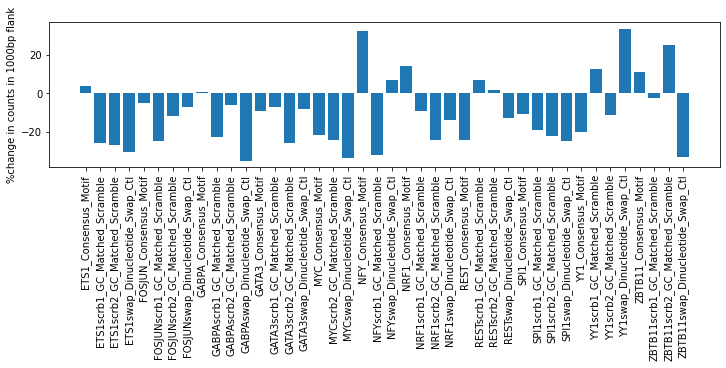

In [35]:
bars_label=np.array(names)[sorted_dix].tolist()
bars_heights=np.array(values)[sorted_dix].tolist()
plt.figure(figsize=(10,5))
plt.bar(range(len(bars_label)), bars_heights)
plt.xticks(range(len(bars_label)), bars_label, rotation='vertical')
plt.tight_layout()
plt.ylabel("%change in counts in 1000bp flank")
plt.show()

In [36]:
from scipy.spatial import distance

def mysign(x):
    if x >= 0: 
        return 1
    else:
        return -1
    
jsd_values = []
jsd_names = []
for idx in range(len(data["Motif"].values)):
    if idx==0:
        continue
    #valt = np.sum(np.abs(np.log(probs[idx]) -  np.log(probs[0])))*np.sign((output_preds[1][idx]-output_preds[1][0])[0])
    valt = (distance.jensenshannon(probs[0], probs[idx]))*np.sign((output_preds[1][idx]-output_preds[1][0])[0])

    jsd_values.append(valt)
    jsd_names.append(data["Motif"].values[idx] + "_" + data["Edit_Type"].values[idx] )

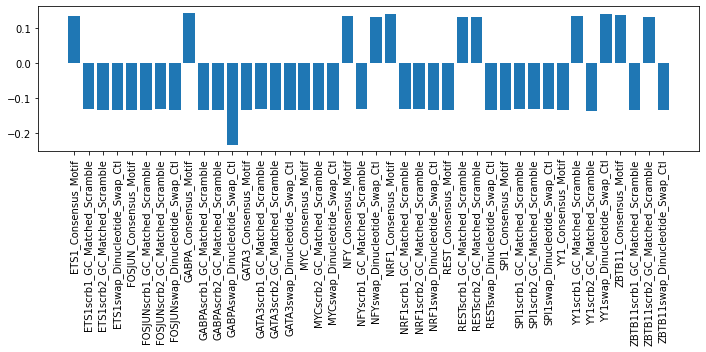

In [37]:
bars_label=np.array(jsd_names)[sorted_dix].tolist()
bars_heights=np.array(jsd_values)[sorted_dix].tolist()
plt.figure(figsize=(10,5))
plt.bar(range(len(bars_label)), bars_heights)
plt.xticks(range(len(bars_label)), bars_label, rotation='vertical')
plt.tight_layout()
plt.show()

WildType_WildType_flank_150.png
YY1_Consensus_Motif_flank_150.png
6.8133717
[-3.250693]%
GABPA_Consensus_Motif_flank_150.png
6.8133717
[0.09389953]%
ETS1_Consensus_Motif_flank_150.png
6.8133717
[0.56215847]%
NFY_Consensus_Motif_flank_150.png
6.8133717
[4.079895]%
NRF1_Consensus_Motif_flank_150.png
6.8133717
[1.934077]%
SPI1_Consensus_Motif_flank_150.png
6.8133717
[-1.7046506]%
GATA3_Consensus_Motif_flank_150.png
6.8133717
[-1.4233929]%
MYC_Consensus_Motif_flank_150.png
6.8133717
[-3.598129]%
FOSJUN_Consensus_Motif_flank_150.png
6.8133717
[-0.7736266]%
ZBTB11_Consensus_Motif_flank_150.png
6.8133717
[1.5494998]%
REST_Consensus_Motif_flank_150.png
6.8133717
[-4.0186157]%
YY1swap_Dinucleotide_Swap_Ctl_flank_150.png
6.8133717
[4.2223854]%
GABPAswap_Dinucleotide_Swap_Ctl_flank_150.png
6.8133717
[-6.323]%
ETS1swap_Dinucleotide_Swap_Ctl_flank_150.png
6.8133717
[-5.2944446]%
NFYswap_Dinucleotide_Swap_Ctl_flank_150.png
6.8133717
[0.9700619]%
NRF1swap_Dinucleotide_Swap_Ctl_flank_150.png
6.8133717

/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZBTB11swap_Dinucleotide_Swap_Ctl_flank_150.png
6.8133717
[-5.9231734]%
RESTswap_Dinucleotide_Swap_Ctl_flank_150.png
6.8133717
[-2.0384045]%
YY1scrb1_GC_Matched_Scramble_flank_150.png
6.8133717
[1.7312801]%
GABPAscrb1_GC_Matched_Scramble_flank_150.png
6.8133717
[-3.7996733]%
ETS1scrb1_GC_Matched_Scramble_flank_150.png
6.8133717
[-4.3564706]%
NFYscrb1_GC_Matched_Scramble_flank_150.png
6.8133717
[-5.7078767]%
NRF1scrb1_GC_Matched_Scramble_flank_150.png
6.8133717
[-1.4410852]%
SPI1scrb1_GC_Matched_Scramble_flank_150.png
6.8133717
[-3.1197221]%
GATA3scrb1_GC_Matched_Scramble_flank_150.png
6.8133717
[-1.1017396]%
FOSJUNscrb1_GC_Matched_Scramble_flank_150.png
6.8133717
[-4.1607704]%
ZBTB11scrb1_GC_Matched_Scramble_flank_150.png
6.8133717
[-0.3732956]%
RESTscrb1_GC_Matched_Scramble_flank_150.png
6.8133717
[0.9720285]%
YY1scrb2_GC_Matched_Scramble_flank_150.png
6.8133717
[-1.7923774]%
GABPAscrb2_GC_Matched_Scramble_flank_150.png
6.8133717
[-0.91718084]%
ETS1scrb2_GC_Matched_Scramble_flank_150.p

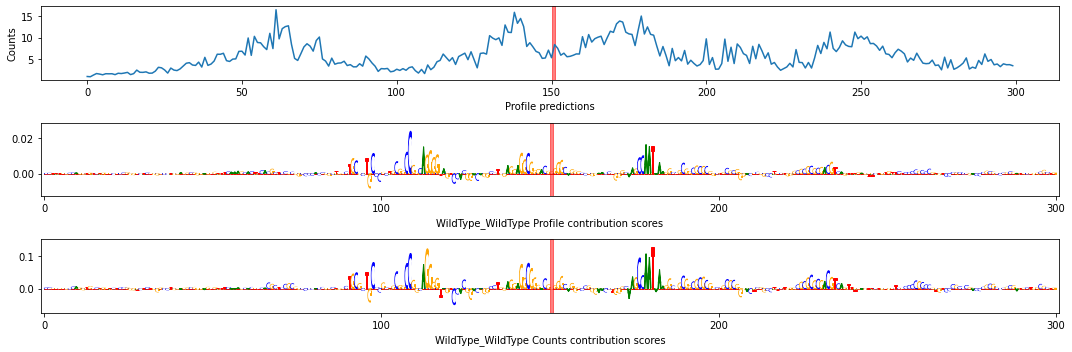

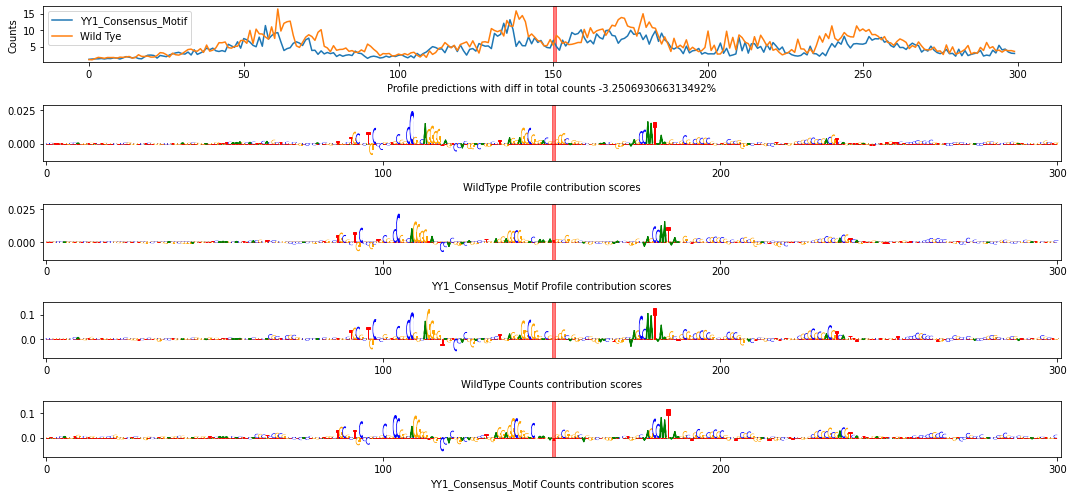

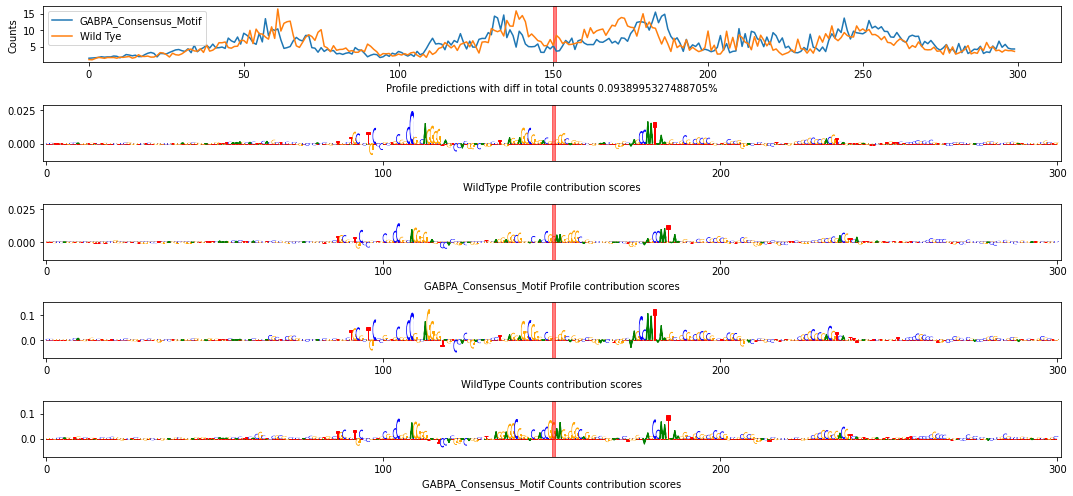

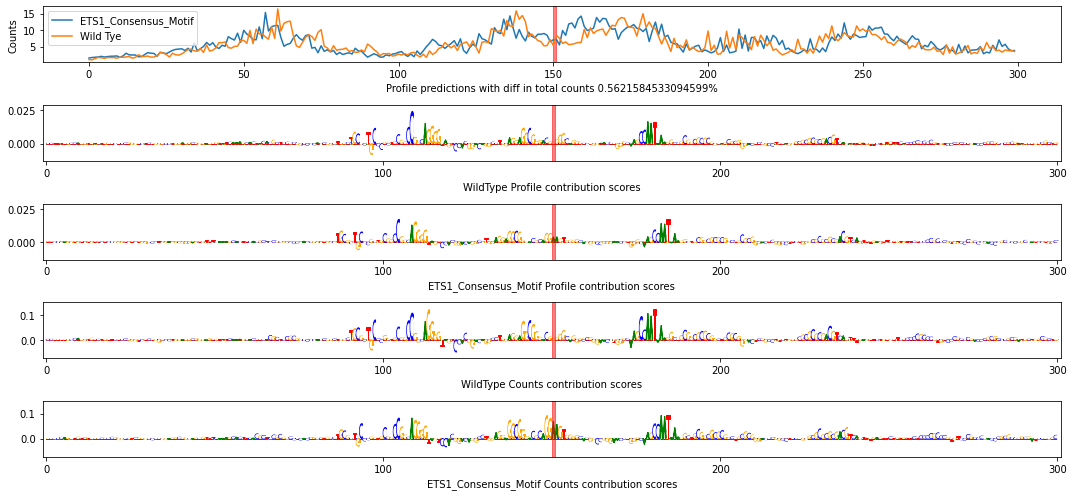

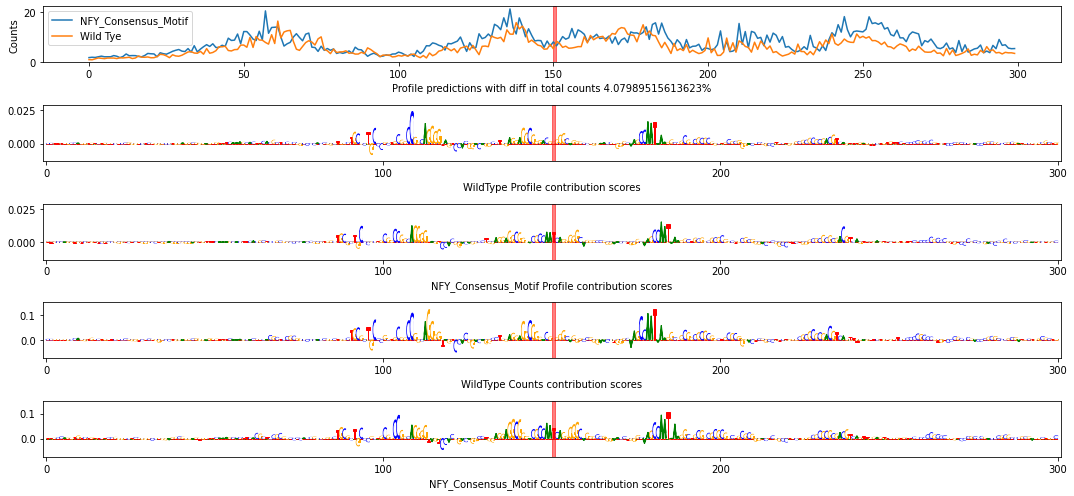

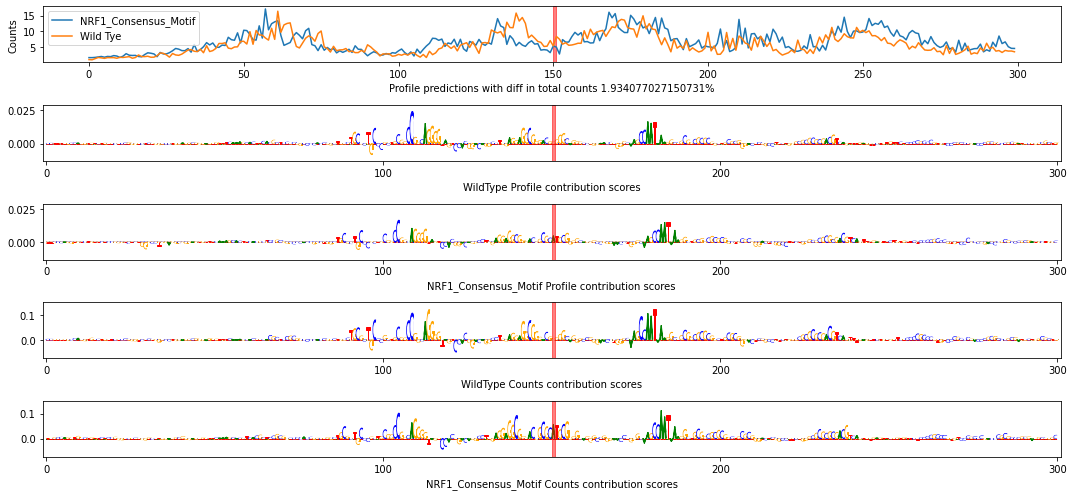

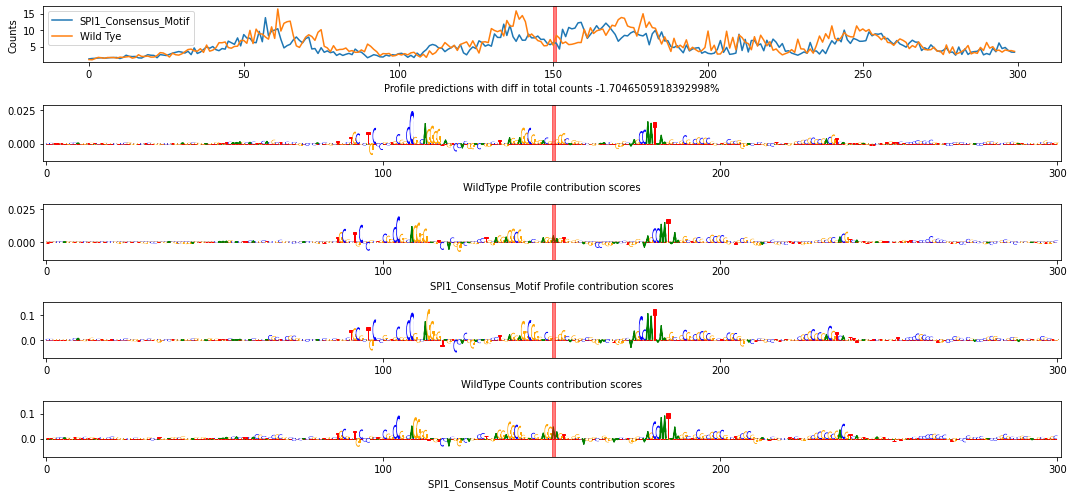

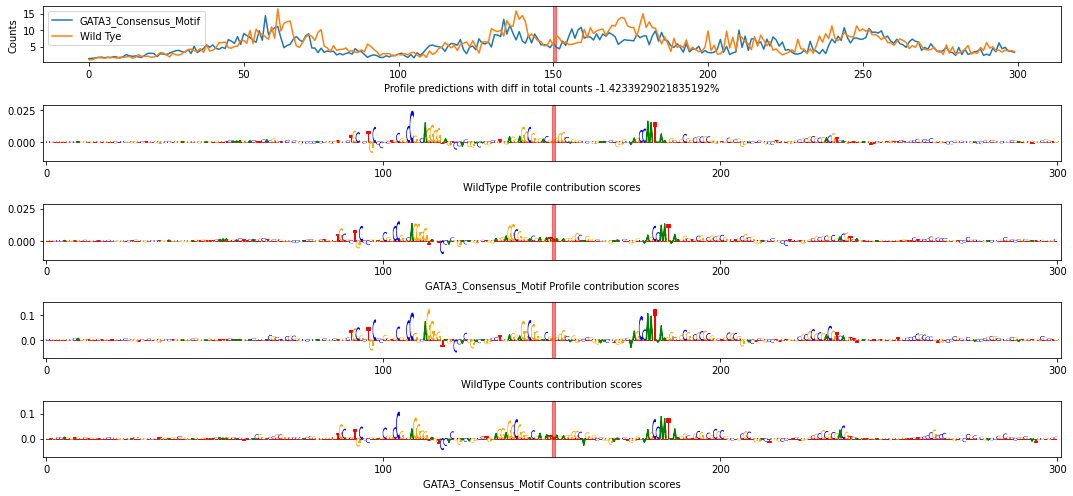

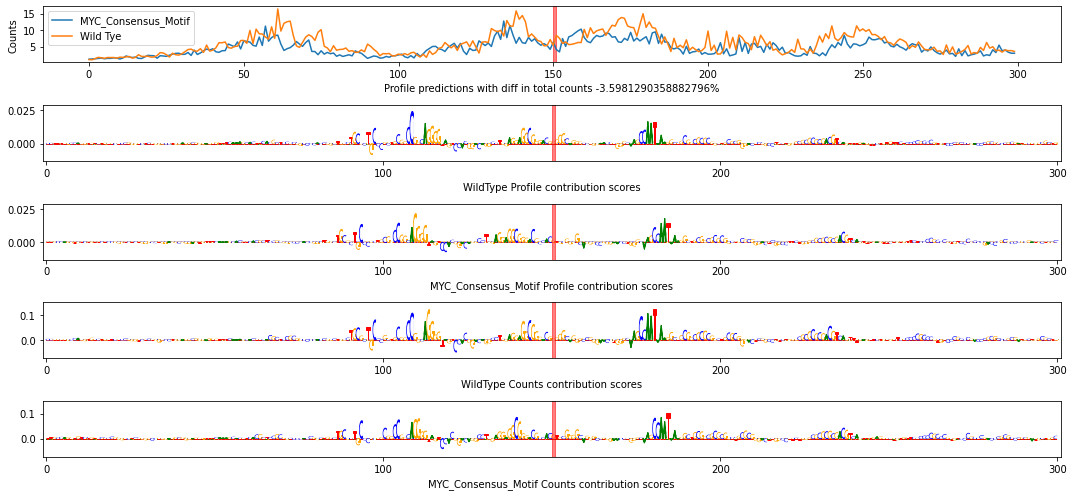

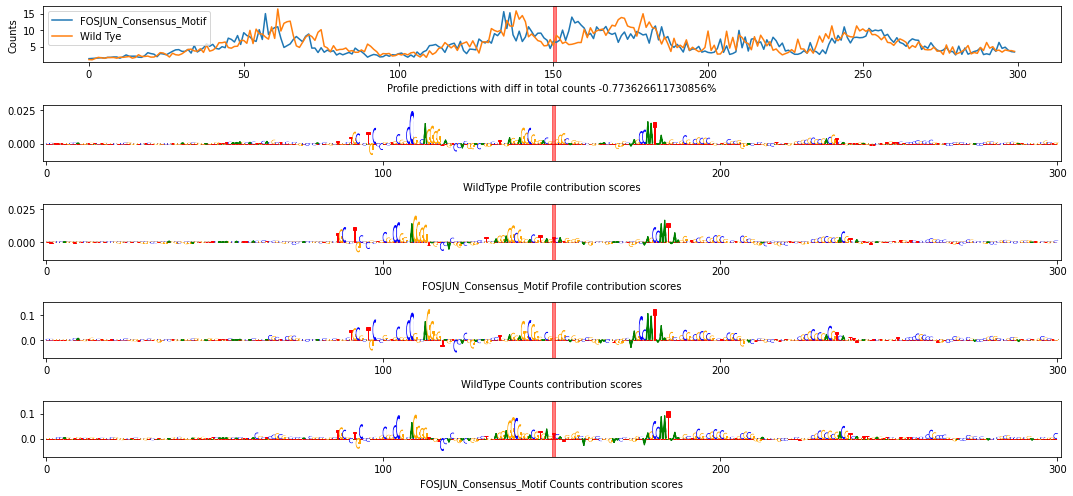

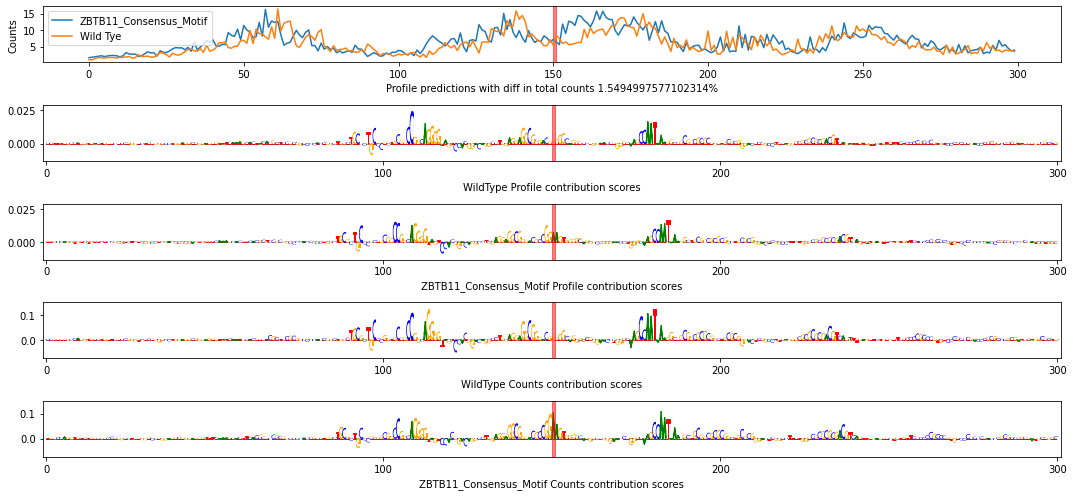

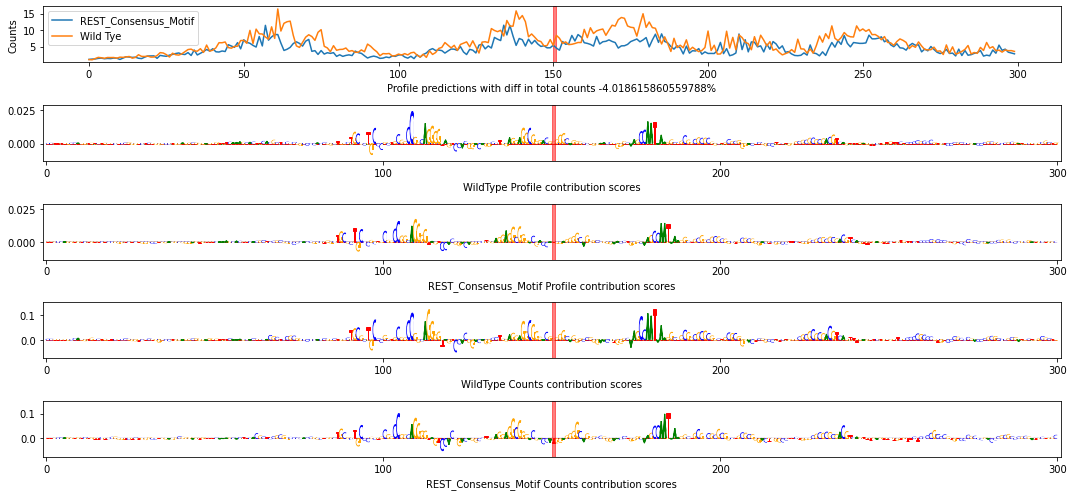

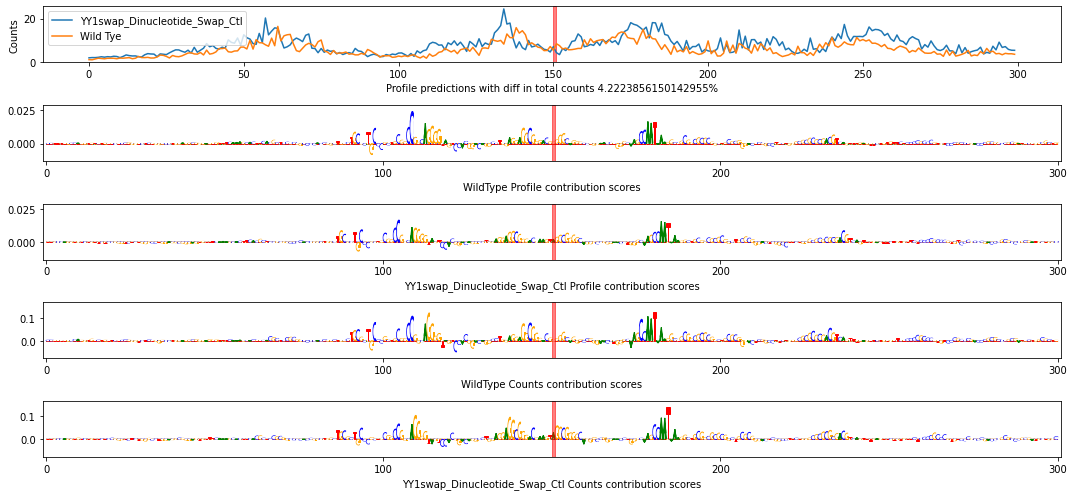

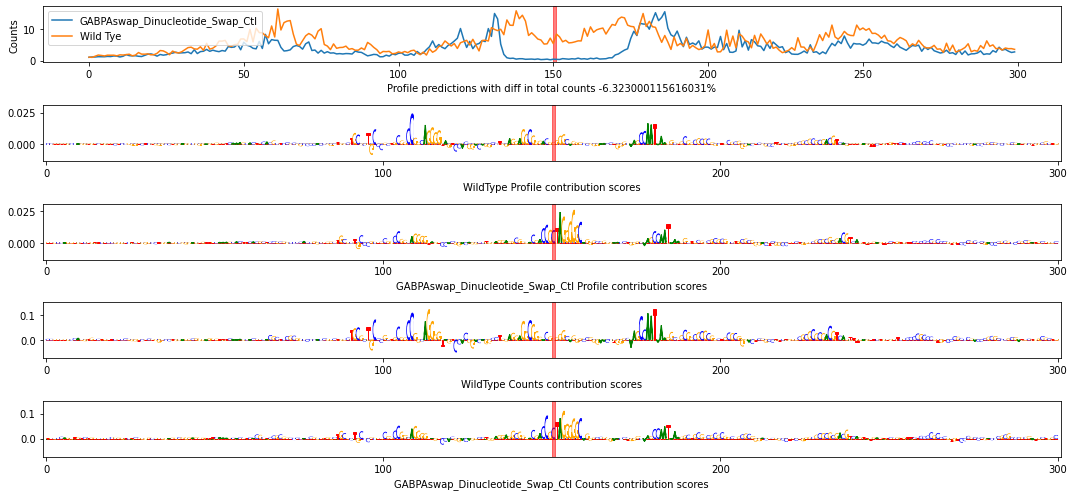

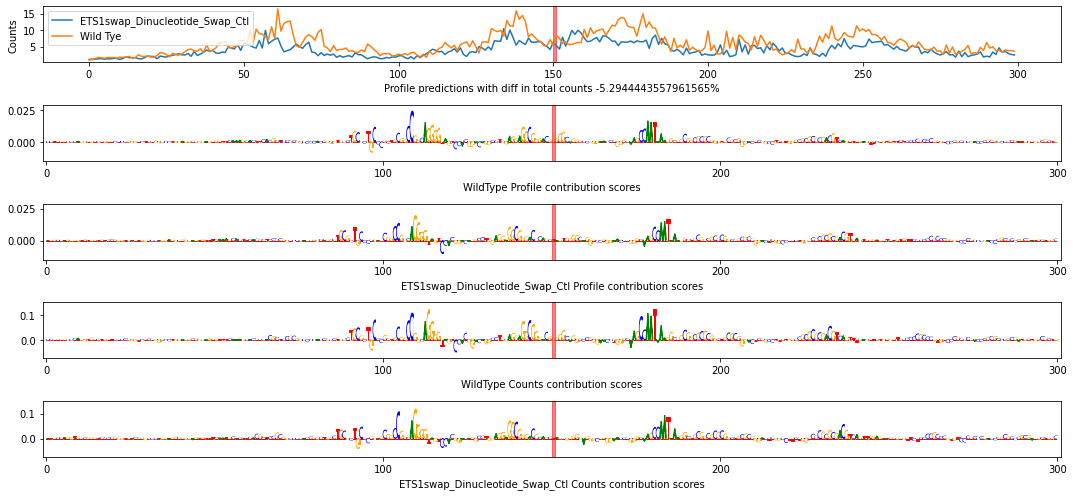

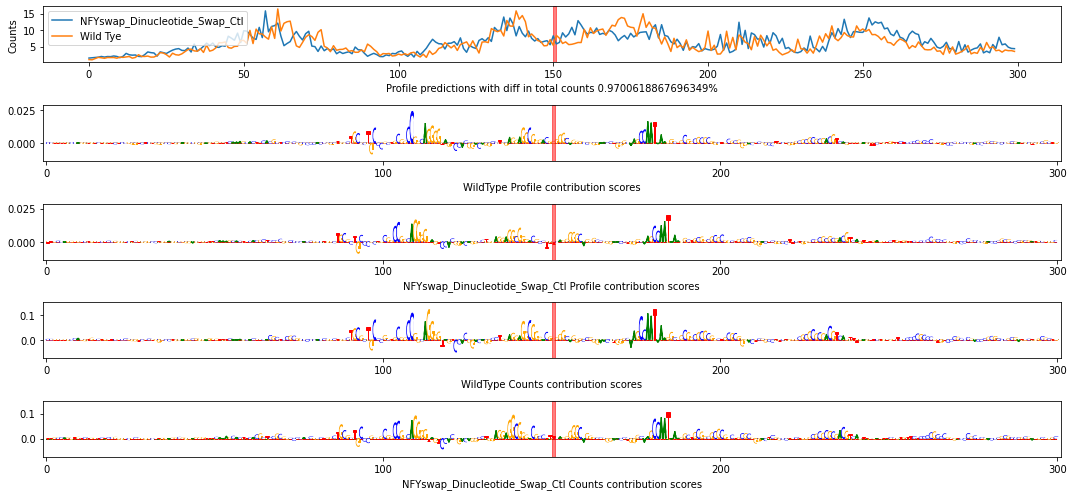

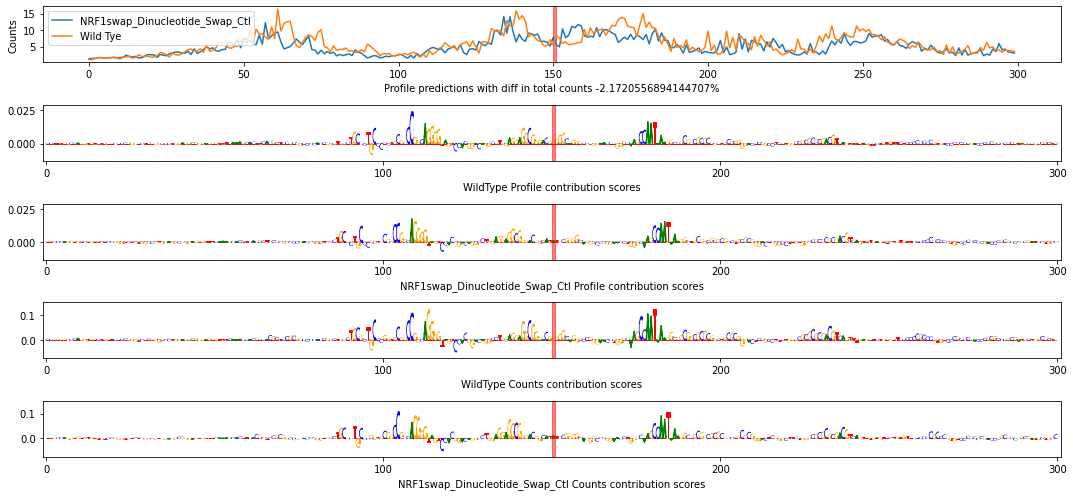

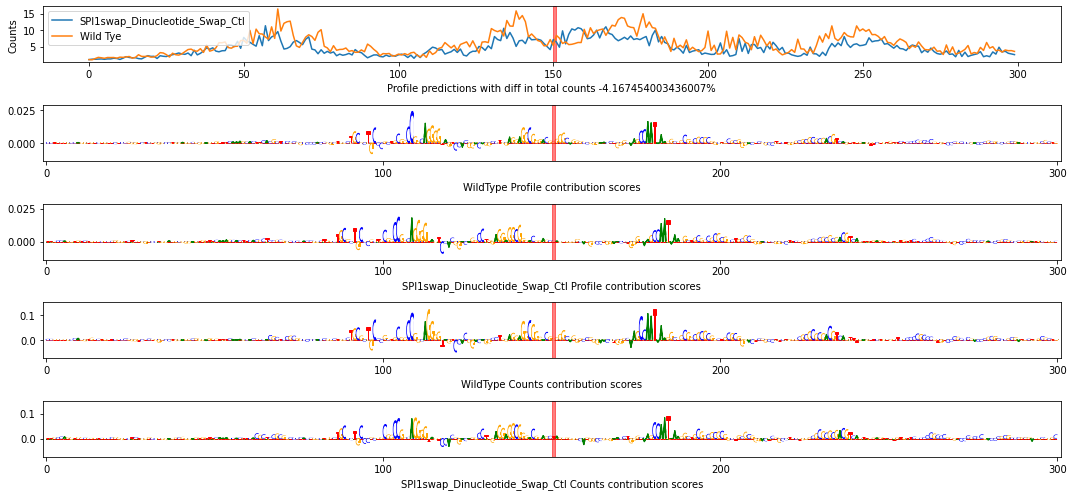

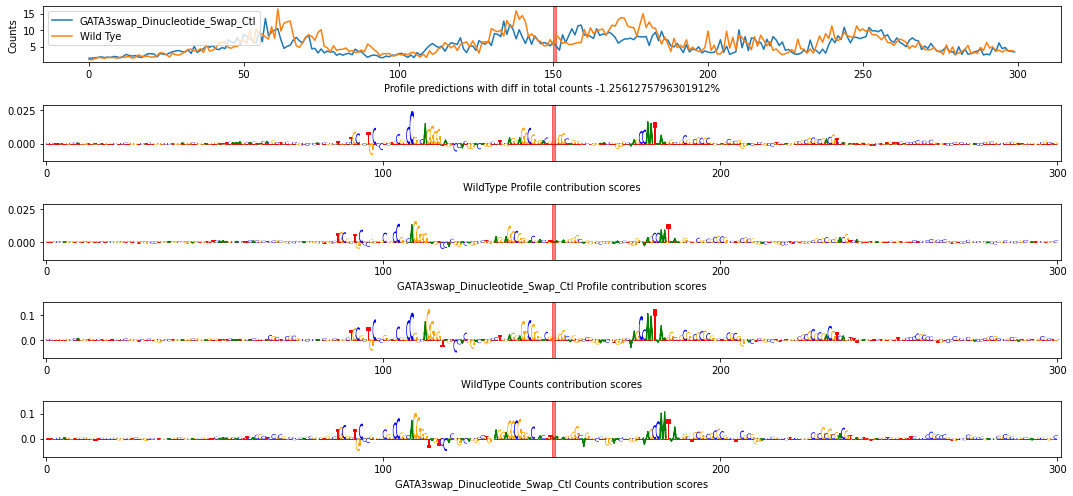

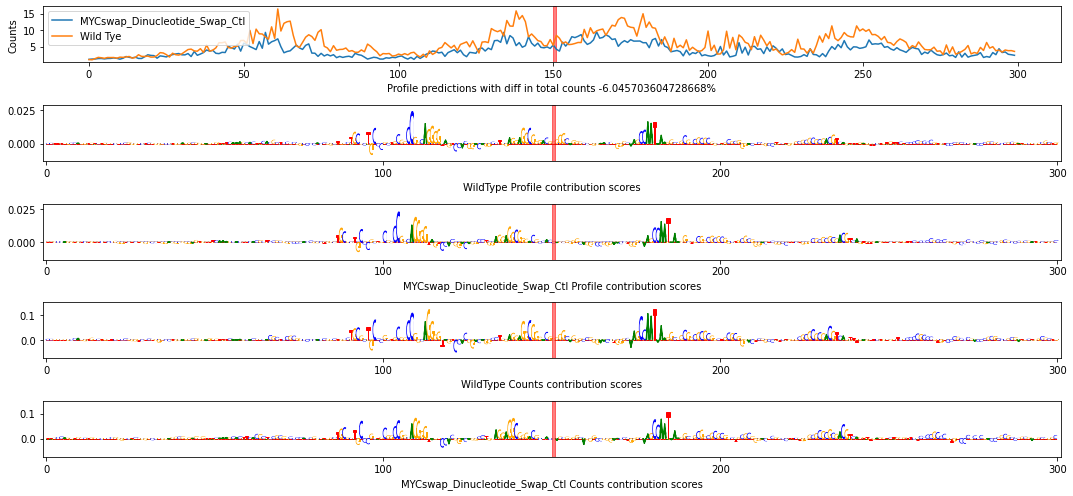

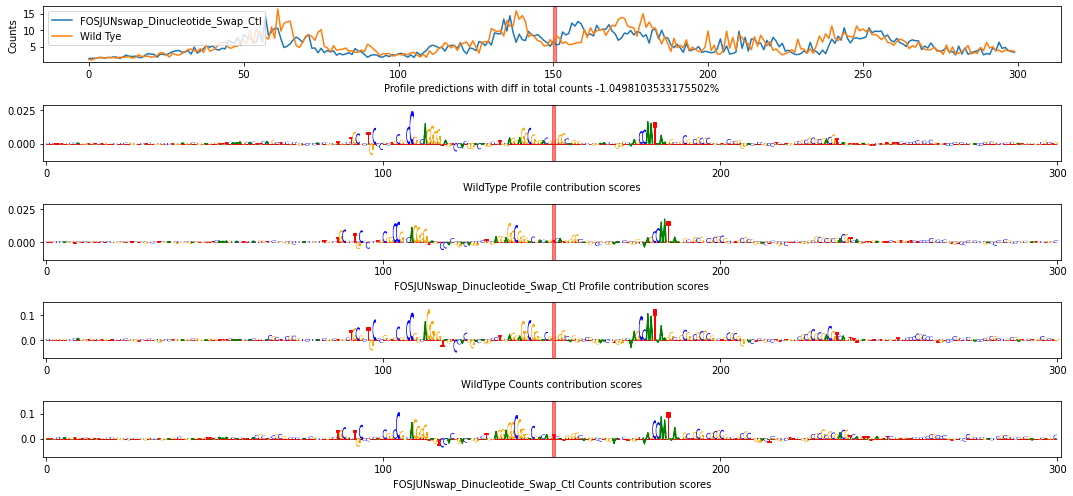

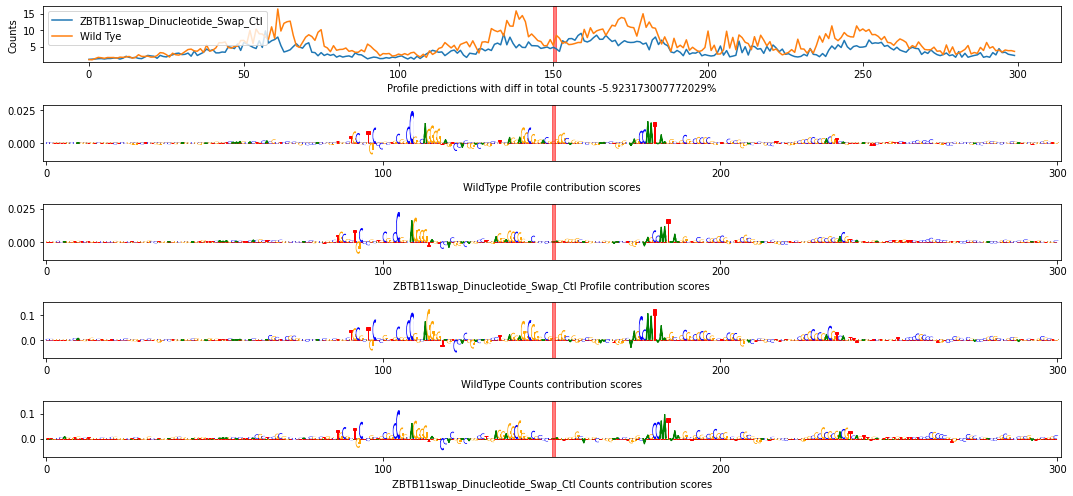

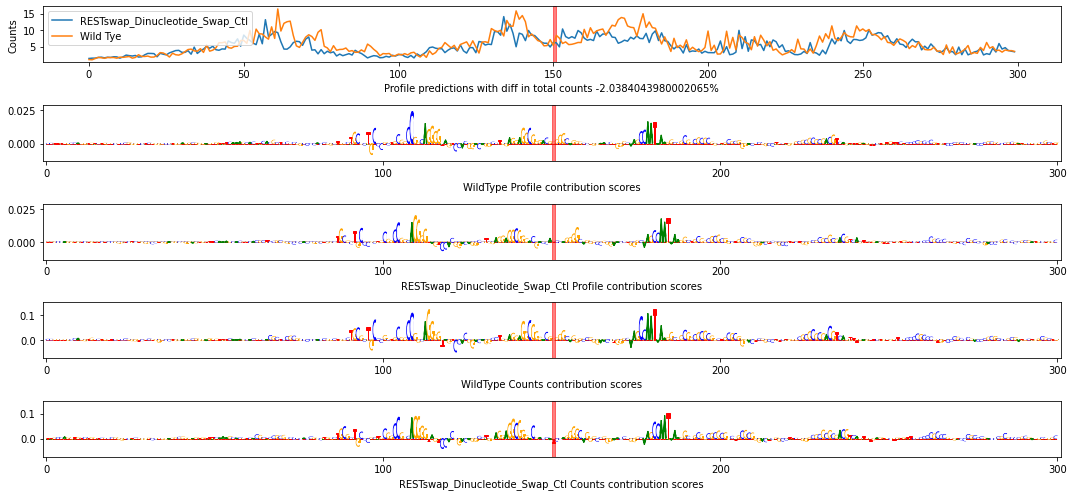

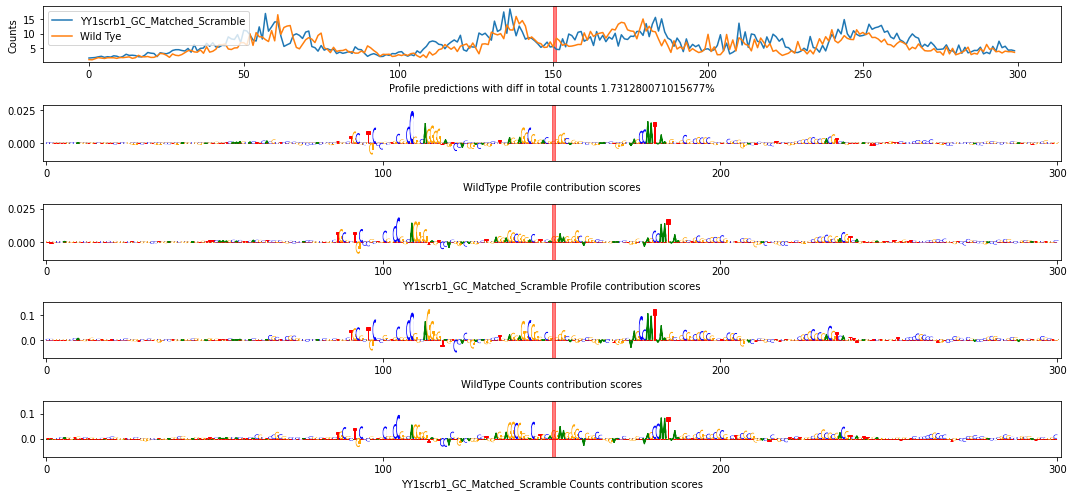

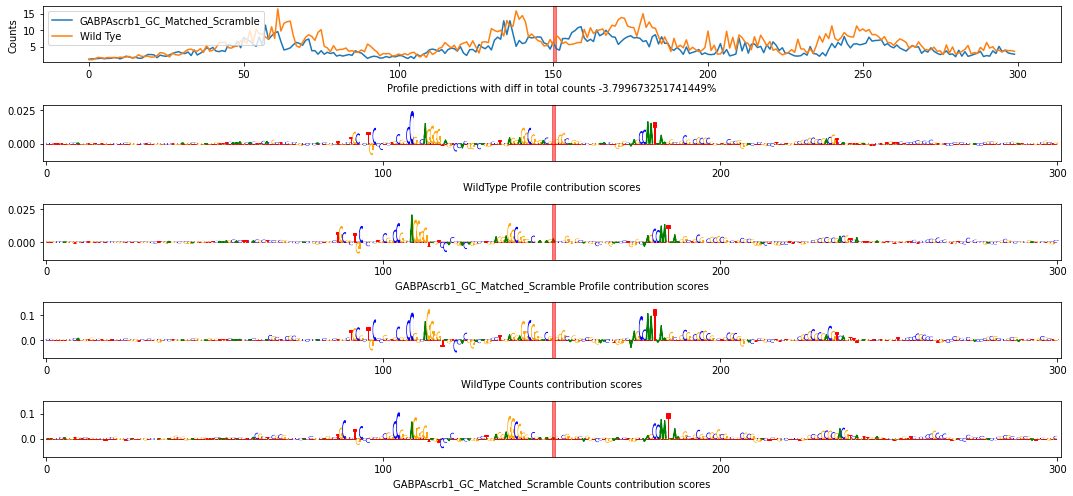

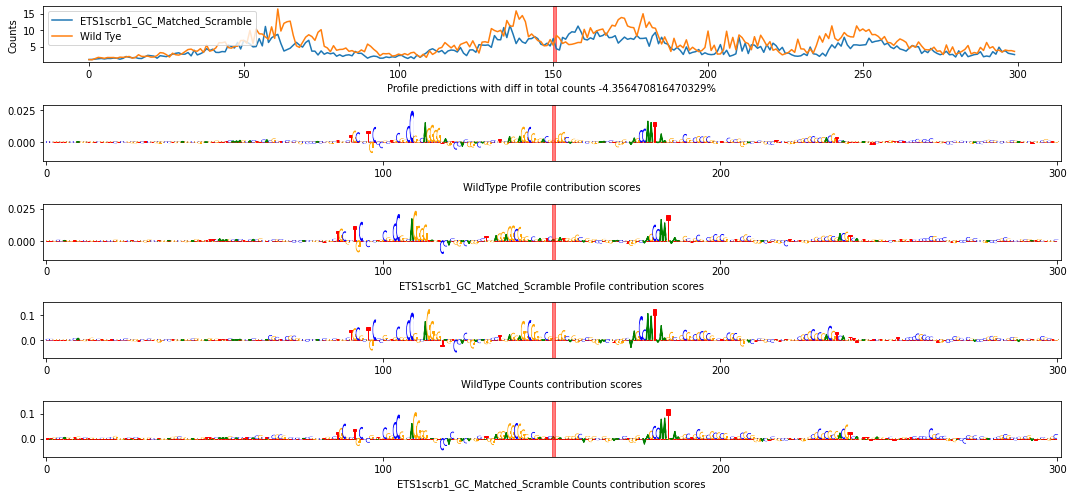

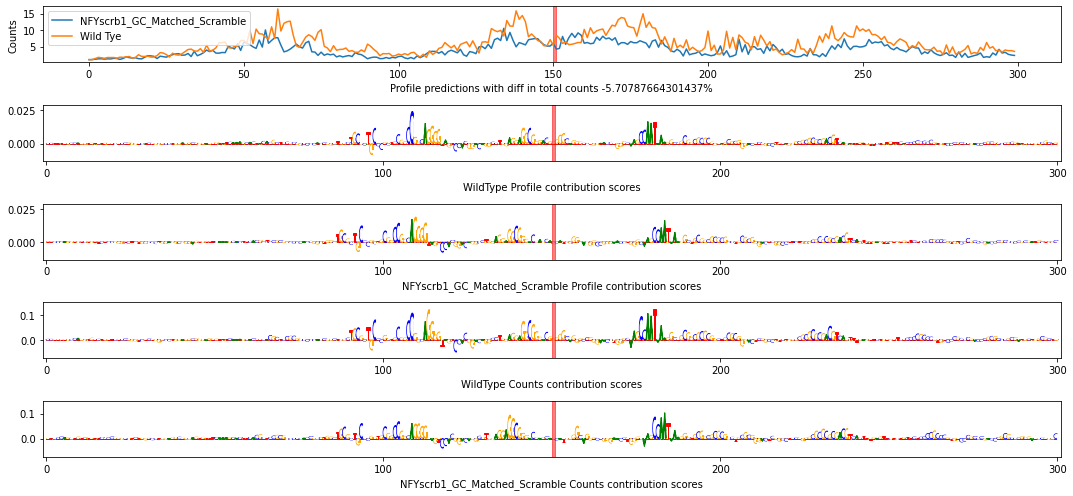

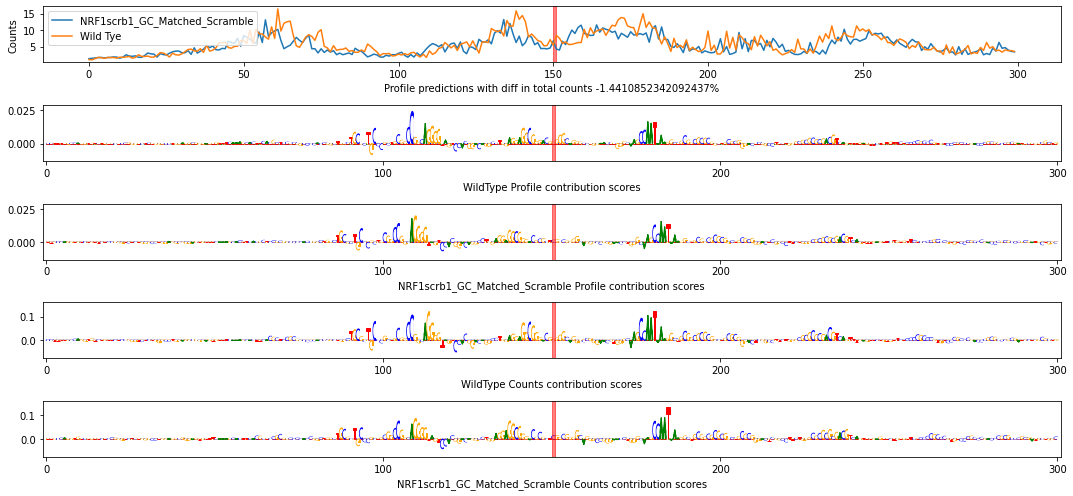

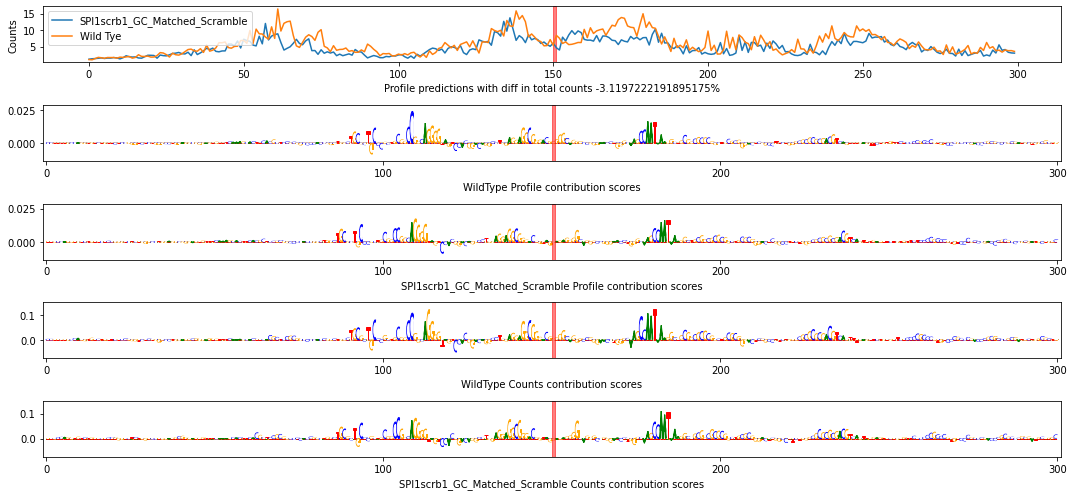

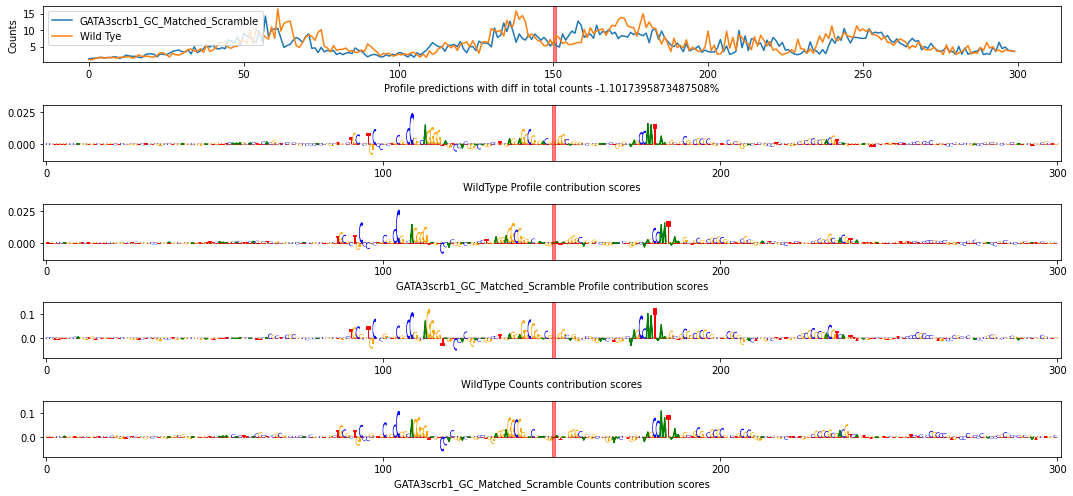

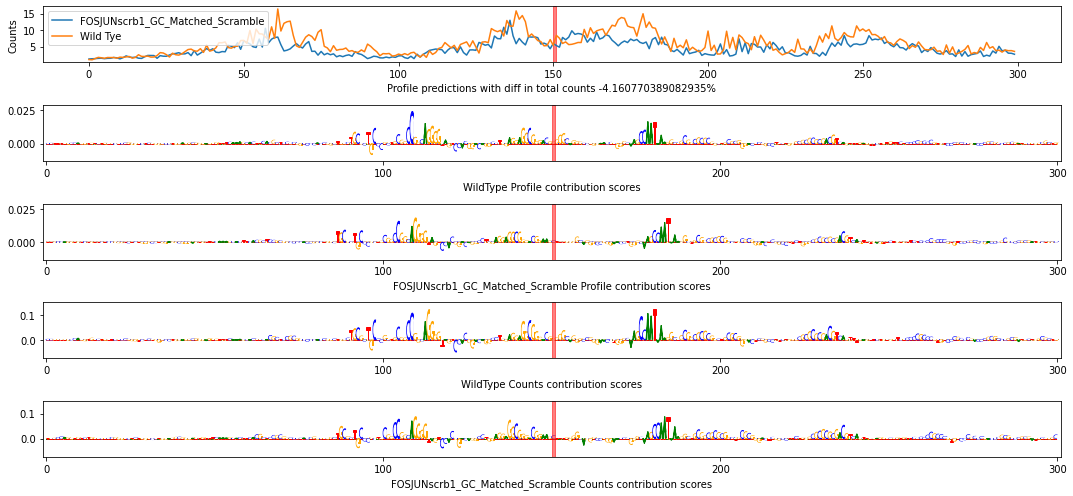

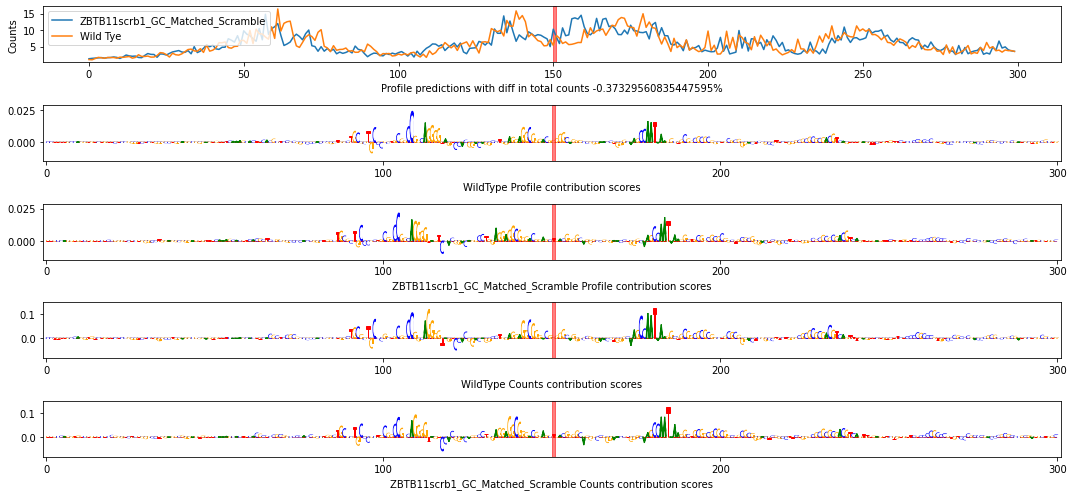

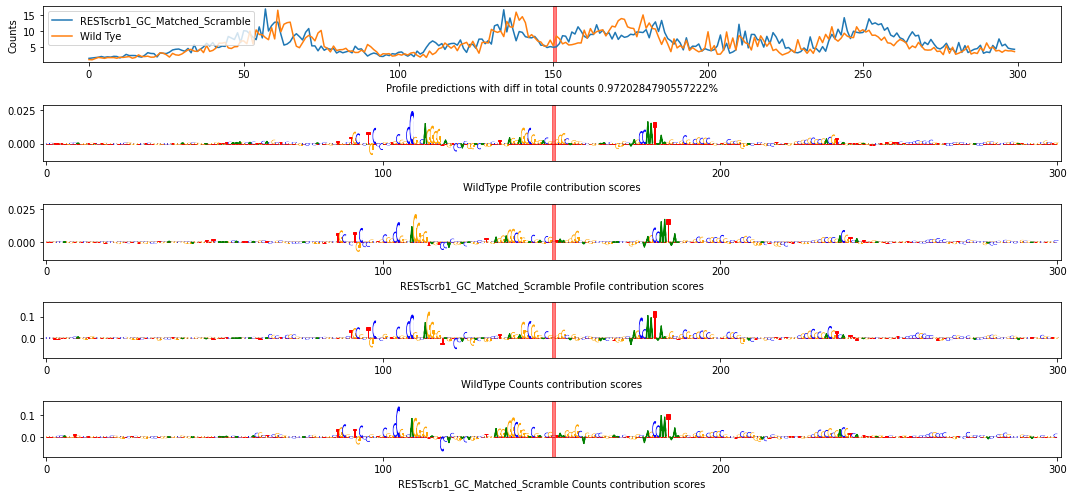

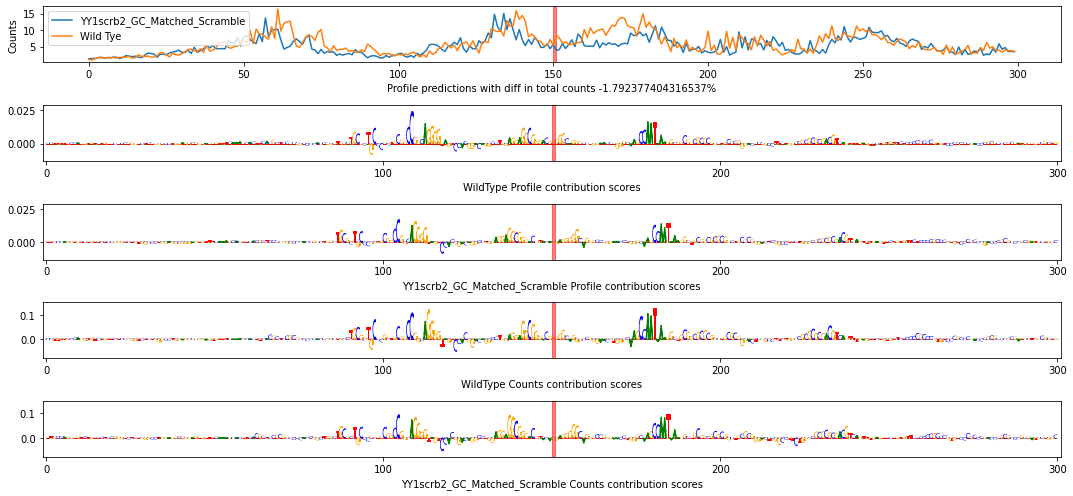

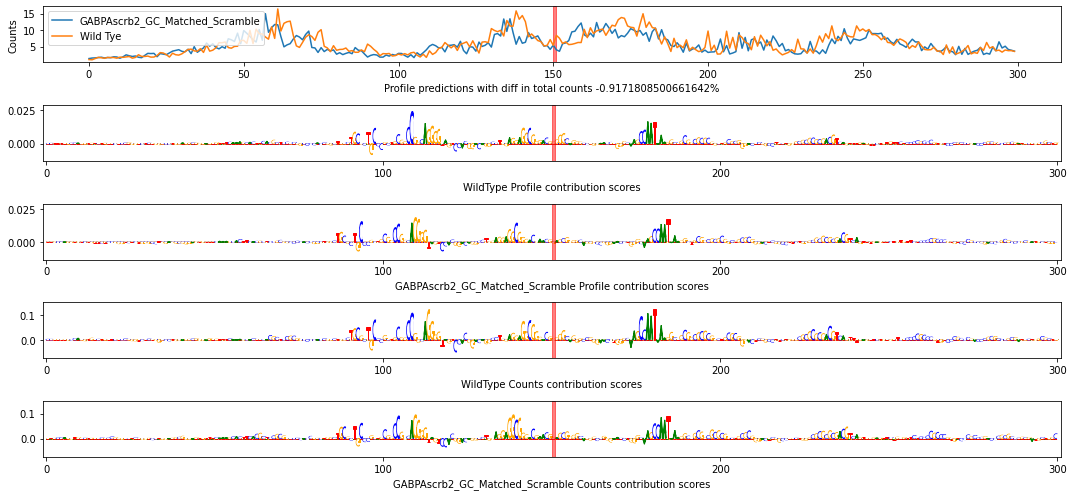

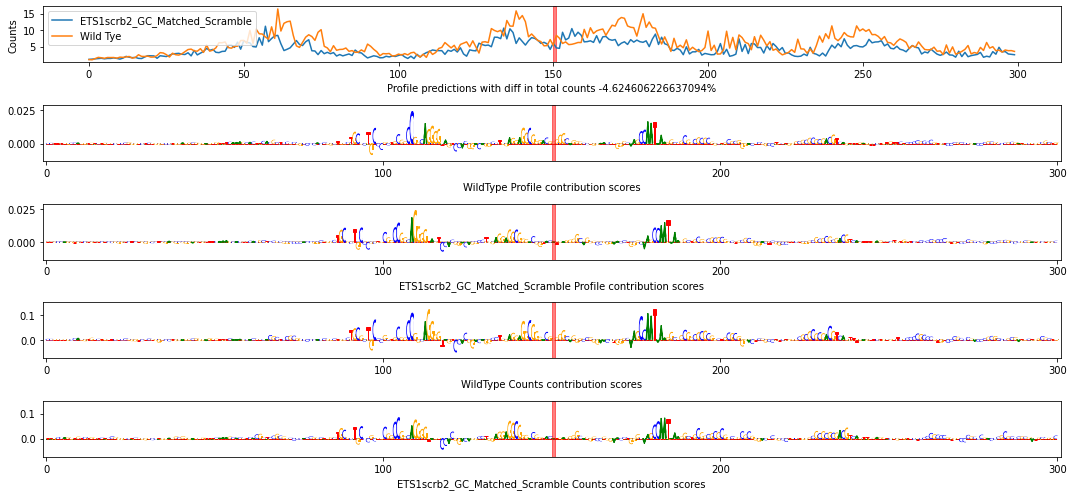

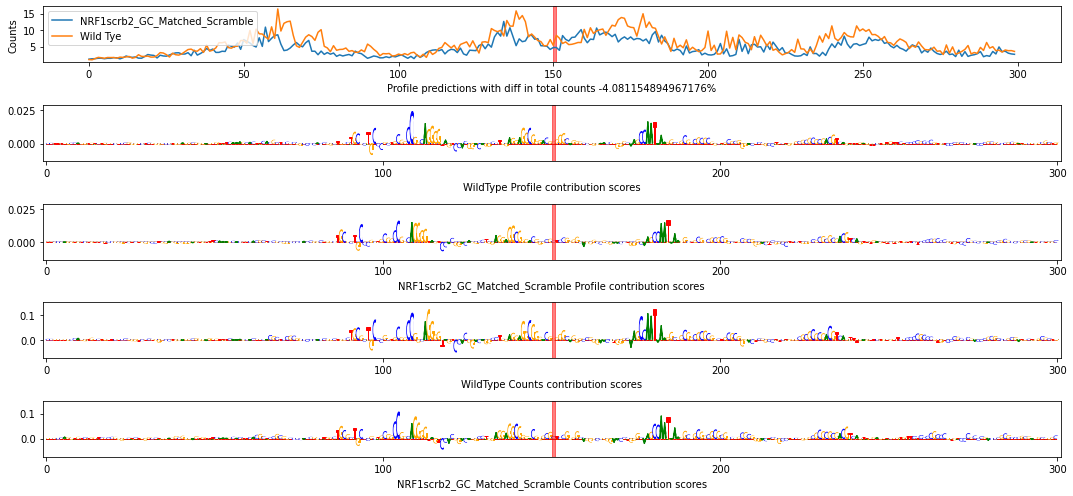

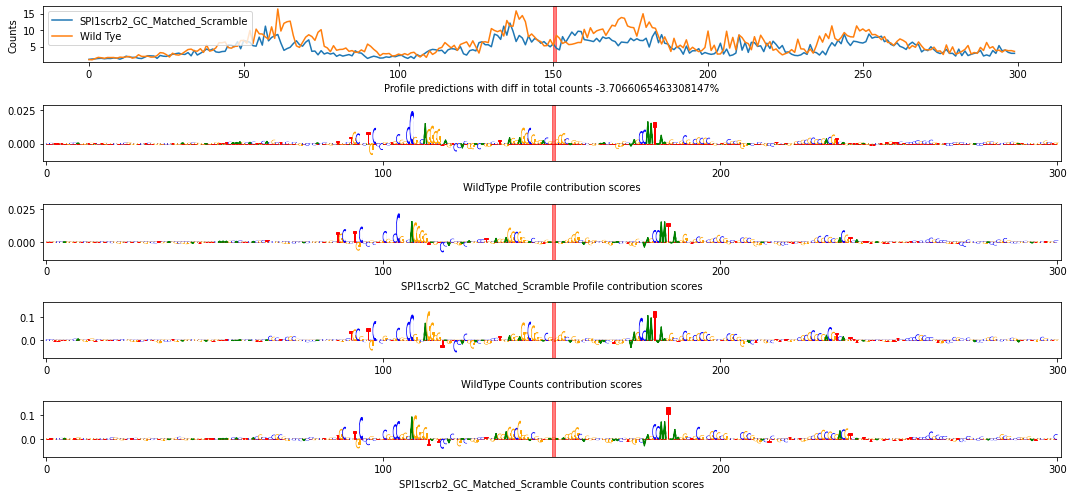

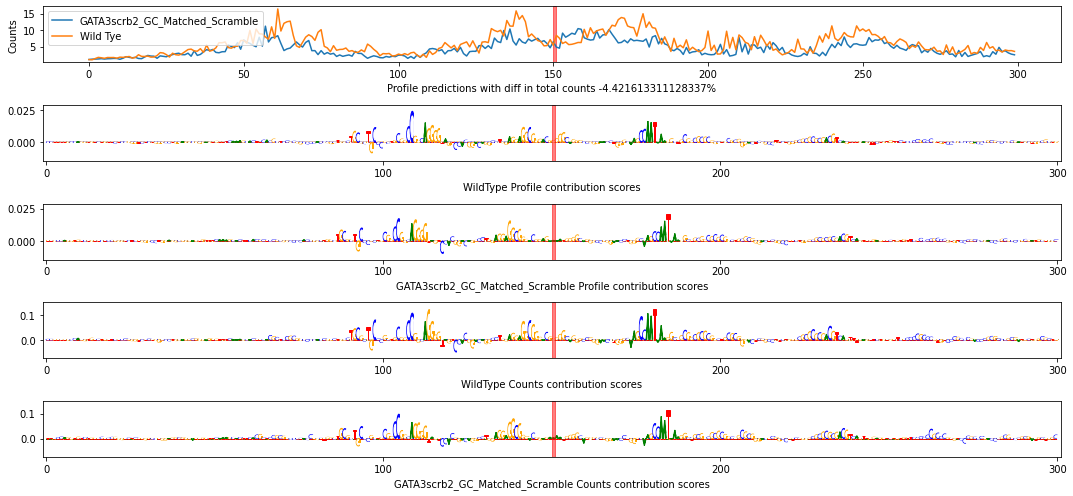

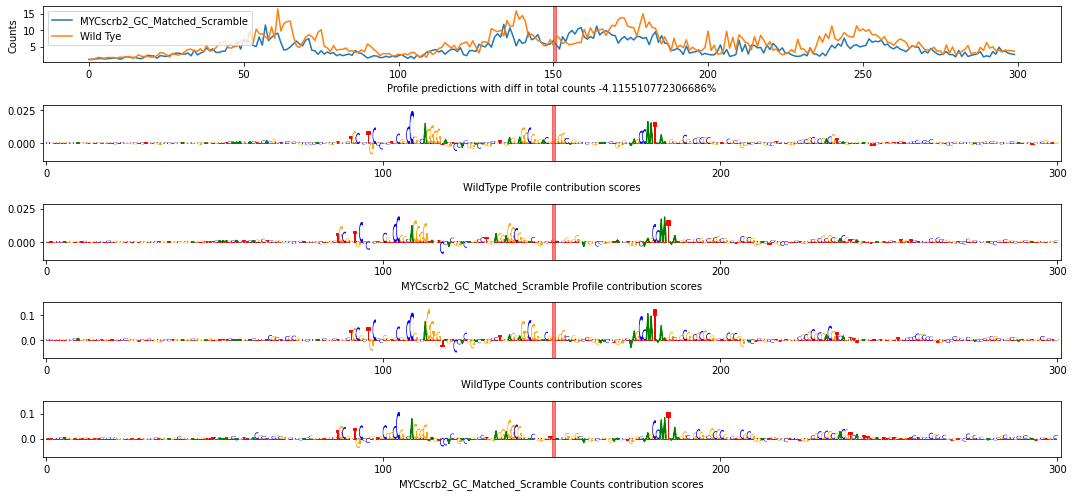

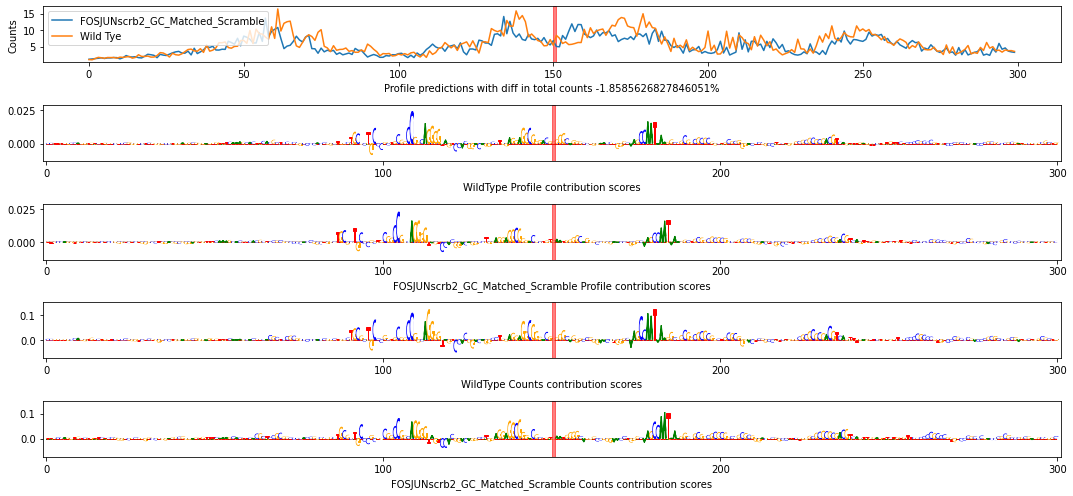

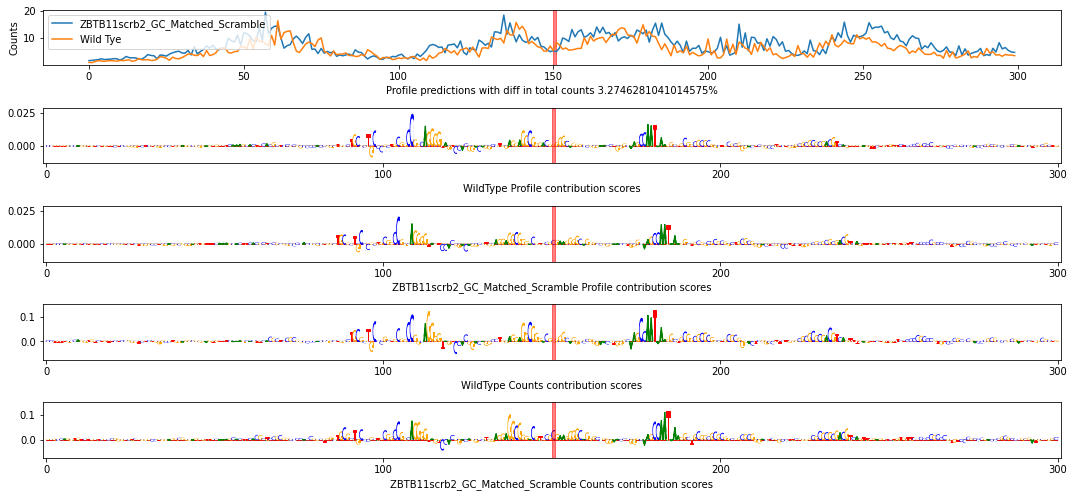

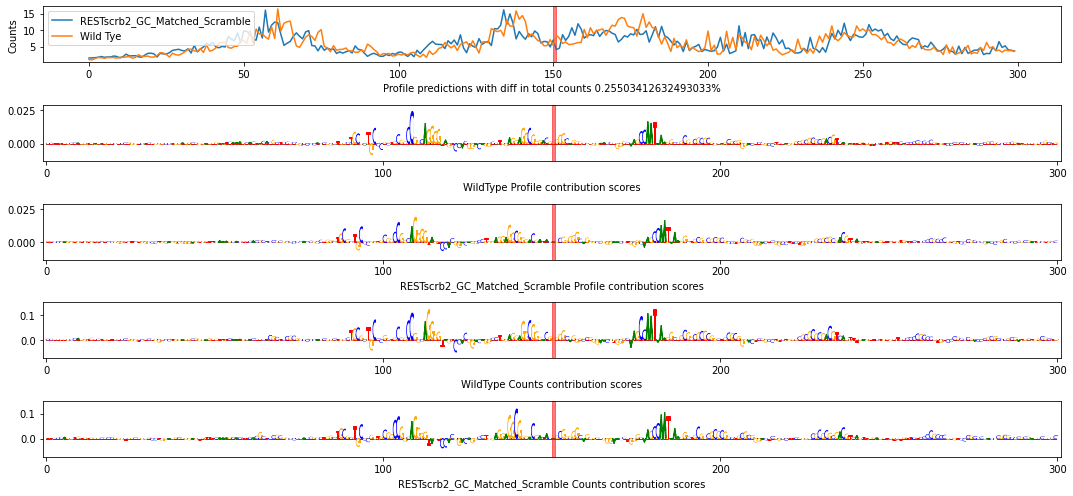

In [38]:

for idx in range(len(data["Motif"].values)):

    fig_name = data["Motif"].values[idx] + "_" + data["Edit_Type"].values[idx] + "_flank_" + str(flank)+ ".png"

    print(fig_name)
    
    if idx ==0 :
        fig, axs = plt.subplots(3, 1, figsize=(15,5))
        
        axs[0].plot(probs[idx,500-flank:500+flank]*np.exp(output_preds[1][idx]+1))
        axs[0].axvspan(flank, flank+1, color='red', alpha=0.5)
        axs[0].set_ylabel('Counts')
        axs[0].set_xlabel('Profile predictions')
        
        last_ax=0
        ytup_p=None
        ytup_c=None    
    else:
        fig, axs = plt.subplots(5, 1, figsize=(15,7))
        print(output_preds[1][0][0])
        print(str((output_preds[1][idx]-output_preds[1][0])[0]*100.0/output_preds[1][0]) + "%")
        axs[0].plot(probs[idx,500-flank:500+flank]*np.exp(output_preds[1][idx]+1), label=data["Motif"].values[idx] + "_" + data["Edit_Type"].values[idx])
        axs[0].plot(probs[0,500-flank:500+flank]*np.exp(output_preds[1][0]+1), label="Wild Tye")
        axs[0].axvspan(flank, flank+1, color='red', alpha=0.5)
        axs[0].set_ylabel('Counts')
        axs[0].set_xlabel('Profile predictions with diff in total counts '+ str((output_preds[1][idx]-output_preds[1][0])[0]*100.0/output_preds[1][0][0]) + "%")
        axs[0].legend()
        
        pylims_min = min(np.min(profile_scores[0][(input_length // 2) - flank:(input_length // 2) + flank]), np.min(profile_scores[idx][(input_length // 2) - flank:(input_length // 2) + flank]))
        pylims_max = max(np.max(profile_scores[0][(input_length // 2) - flank:(input_length // 2) + flank]), np.max(profile_scores[idx][(input_length // 2) - flank:(input_length // 2) + flank]))
        cylims_min = min(np.min(counts_scores[0][(input_length // 2) - flank:(input_length // 2) + flank]), np.min(counts_scores[idx][(input_length // 2) - flank:(input_length // 2) + flank]))
        cylims_max = max(np.max(counts_scores[0][(input_length // 2) - flank:(input_length // 2) + flank]), np.max(counts_scores[idx][(input_length // 2) - flank:(input_length // 2) + flank]))

        last_ax = 0
        
        viz_sequence.plot_weights_given_ax(ax=axs[last_ax+1], array=profile_scores[0][(input_length // 2) - flank:(input_length // 2) + flank],
            height_padding_factor=0.2,
            length_padding=1.0,
            subticks_frequency=100,
            colors=viz_sequence.default_colors,
            plot_funcs=viz_sequence.default_plot_funcs,
            highlight={},
            ylabel="",
            ylim=(pylims_min, pylims_max))
        axs[last_ax+1].axvspan(flank, flank+1, color='red', alpha=0.5)
        axs[last_ax+1].set_xlabel('WildType Profile contribution scores')

        
        last_ax=1
        ytup_p=(pylims_min, pylims_max)
        ytup_c=(cylims_min, cylims_max)


    viz_sequence.plot_weights_given_ax(ax=axs[last_ax+1], array=profile_scores[idx][(input_length // 2) - flank:(input_length // 2) + flank],
            height_padding_factor=0.2,
            length_padding=1.0,
            subticks_frequency=100,
            colors=viz_sequence.default_colors,
            plot_funcs=viz_sequence.default_plot_funcs,
            highlight={},
            ylabel="",
            ylim=ytup_p)
    axs[last_ax+1].axvspan(flank, flank+1, color='red', alpha=0.5)
    axs[last_ax+1].set_xlabel(data["Motif"].values[idx] + "_" + data["Edit_Type"].values[idx] + ' Profile contribution scores')

    if idx>0:
        viz_sequence.plot_weights_given_ax(ax=axs[last_ax+2], array=counts_scores[0][(input_length // 2) - flank:(input_length // 2) + flank],
            height_padding_factor=0.2,
            length_padding=1.0,
            subticks_frequency=100,
            colors=viz_sequence.default_colors,
            plot_funcs=viz_sequence.default_plot_funcs,
            highlight={},
            ylabel="",
            ylim=ytup_c)
        axs[last_ax+2].axvspan(flank, flank+1, color='red', alpha=0.5)
        axs[last_ax+2].set_xlabel('WildType Counts contribution scores') 
        last_ax += 1
    
    viz_sequence.plot_weights_given_ax(ax=axs[last_ax+2], array=counts_scores[idx][(input_length // 2) - flank:(input_length // 2) + flank],
            height_padding_factor=0.2,
            length_padding=1.0,
            subticks_frequency=100,
            colors=viz_sequence.default_colors,
            plot_funcs=viz_sequence.default_plot_funcs,
            highlight={},
            ylabel="",
            ylim=ytup_c)
    axs[last_ax+2].axvspan(flank, flank+1, color='red', alpha=0.5)
    axs[last_ax+2].set_xlabel(data["Motif"].values[idx] + "_" + data["Edit_Type"].values[idx] + ' Counts contribution scores')
    

    fig.tight_layout()
    plt.savefig(odir+fig_name)
    

In [20]:
valuesn = []
for idx in range(len(data["Motif"].values)):
    valuesn.append((output_preds[1][idx]-output_preds[1][0])[0])

jsd_values = []
jsd_names = []
for idx in range(len(data["Motif"].values)):
    #valt = np.sum(np.abs(np.log(probs[idx]) -  np.log(probs[0])))*np.sign((output_preds[1][idx]-output_preds[1][0])[0])
    valt = (distance.jensenshannon(probs[0], probs[idx]))*np.sign((output_preds[1][idx]-output_preds[1][0])[0])

    jsd_values.append(valt)
    jsd_names.append(data["Motif"].values[idx] + "_" + data["Edit_Type"].values[idx] )

data["diff_in_logcounts_preds"] = valuesn

#data["diff_in_logcounts_preds"] = jsd_values

#data["diff_in_logcounts_preds_percentage_change"] = jsd_values


In [21]:
data.to_csv("pPPIF_Motif_Insertions_2022-03-14_V3_diff_in_log_counts_preds.csv", index=False, header=True, sep=",")

In [82]:
values = []
names = []
for idx in range(len(data["Motif"].values)):
    #values.append(((output_preds[1][idx]-output_preds[1][0])[0])*100.0/output_preds[1][0][0])
    values.append(((np.exp(output_preds[1][idx]+1)-np.exp(output_preds[1][0]+1))[0]*100.0/np.exp(output_preds[1][0]+1)[0]))
    names.append(data["Motif"].values[idx] + "_" + data["Edit_Type"].values[idx] )

In [83]:
sorted_dix  = np.argsort(names)

In [84]:
np.array(values)[sorted_dix].tolist()

[26.05598813489611,
 6.164062703027159,
 7.284437742432752,
 10.14575147046832,
 30.1319478613449,
 23.079082606285844,
 3.886214112977374,
 8.081814994971332,
 16.399597508930647,
 11.956998319332504,
 17.243233703769068,
 27.495854812352828,
 7.238104726566379,
 11.568976286643961,
 -3.754647113220397,
 17.553811822647386,
 8.800760686145916,
 -5.7975713870108665,
 4.582999462164179,
 19.497008384695636,
 -10.074980350443278,
 4.790751125100316,
 23.371821341224145,
 8.578910354379671,
 15.772490694662524,
 4.126891476237416,
 -1.1910844314585252,
 12.182663439775197,
 14.395821115052854,
 -0.44954012969417306,
 17.755551181099932,
 8.566416612824442,
 1.5580695712517032,
 13.571209481218986,
 0.0,
 -0.7298345054549318,
 18.73419879653911,
 9.58474296873645,
 29.26796612689876,
 32.2869701324886,
 17.756563519842548,
 10.923289352770484,
 -5.507079550257402]

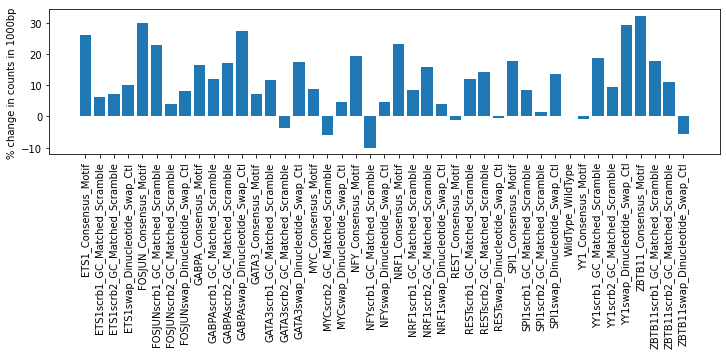

In [86]:
bars_label=np.array(names)[sorted_dix].tolist()
bars_heights=np.array(values)[sorted_dix].tolist()
plt.figure(figsize=(10,5))
plt.bar(range(len(bars_label)), bars_heights)
plt.xticks(range(len(bars_label)), bars_label, rotation='vertical')
plt.tight_layout()
plt.ylabel("% change in counts in 1000bp")
plt.show()

In [26]:
data["diff_in_logcounts_preds_percentage_change"] = values

In [27]:
data.to_csv("pPPIF_Motif_Insertions_2022-03-14_V3_diff_in_log_counts_preds_with_percentage.csv", index=False, header=True, sep=",")

In [28]:
data_v = pd.read_csv("AllelicEffects.byExperimentRep.ExperimentIDReplicates.flat_MTM.csv").dropna(how="all").dropna(axis=1,how="all")

In [29]:
data_v.head()

AmpliconID     MappingSequence VariantID  RefAllele            A  \
0      pPPIF  GGACGCAGGAAGTGGGGC     ETS1i      False  3231.546560   
1      pPPIF  GGACGCAGGAAGTGGGGC     ETS1i      False  3846.655830   
2      pPPIF  GGACGCAGGAAGTGGGGC     ETS1i      False  3197.413131   
3      pPPIF  GGACGCAGGAAGTGGGGC     ETS1i      False  3417.124609   
4      pPPIF  GGACGCAGGAAGTGGGGC     ETS1i      False  3352.489164   

             B            C            D            E            F  ...  \
0  3146.027783  3762.638226  3592.167517  3960.802340  4342.238428  ...   
1  3551.304650  3993.984855  4368.383358  4503.364634  4552.966963  ...   
2  3524.494671  3948.896351  3705.707460  4330.685787  4215.387007  ...   
3  3234.679703  4117.421454  4212.252011  4217.047643  4476.286056  ...   
4  3786.532800  4346.479146  4339.655967  4982.311444  4613.633106  ...   

          sum1  WeightedAvg   logMean     logSD        mean      freq  \
0  22035.42086     2.411260  2.419521  0.368955  307.315647  0.007597   
1  24816.66029     2.336749  2.344050  0.382112  261.249206  0.007710   
2  22922.58441     2.321270  2.334486  0.379902  255.063745  0.007554   
3  23674.81148     2.522481  2.523198  0.365576  389.064025  0.008162   
4  25421.10163     2.594442  2.589170  0.342836  444.568041  0.008222   

   effect_size  pct_change  ExperimentIDReplicates  BioRep  
0     1.080658    8.065764                 1-nan-1       1  
1     1.030202    3.020201                 1-nan-2       1  
2     1.052826    5.282624                 1-nan-3       1  
3     1.072778    7.277834                 2-nan-1       2  
4     1.047798    4.779761                 2-nan-2       2  

[5 rows x 22 columns]